# Autograd Fungsional dengan JAX



Selamat datang di notebook ini. Kita akan mempelajari salah satu fitur paling kuat dari JAX: **Functional Autograd**. 



### Mengapa JAX Berbeda?

Jika kamu terbiasa dengan PyTorch atau TensorFlow, Anda mungkin mencari atribut seperti `.grad` pada tensor. Di JAX, hal itu tidak ada. JAX menggunakan pendekatan **fungsional**: 

1. Mendefinisikan komputasi sebagai **fungsi Python murni**.

2. Menggunakan **transformasi fungsi** (seperti `jax.grad`) untuk menghasilkan fungsi baru yang menghitung gradien.



Pendekatan ini membuat kode lebih mudah diprediksi, lebih mudah diparalelkan, dan sangat cocok untuk optimasi performa tinggi menggunakan compiler XLA.

In [103]:
import os
import pandas as pd
import jax
import jax.numpy as jnp

In [104]:
# Create a 2x2 matrix
W = jnp.array([[1., 2.], [3., 4.]])
print(W)

[[1. 2.]
 [3. 4.]]


In [105]:
def f(w):
    y = w - 2.0
    y = y * y + 3.0
    return y.mean()

a = f(W)
print(f"Value: {a}")

Value: 4.5


### Langkah 1: Menghitung Gradien dengan `jax.grad`



Fungsi `jax.grad(f)` adalah transformasi derifatif suatu fungsi ke tingkat yang lebih tinggi (*higher-order*). Ia menerima fungsi `f` dan mengembalikan fungsi baru yang menghitung turunan pertama dari `f` terhadap argumen pertamanya.



**Contoh Matematika:**

Misalkan kita punya fungsi:

$$f(w) = (w - 2.0)^2 + 3.0$$

Secara manual, turunannya adalah:

$$f'(w) = 2(w - 2.0)$$



Mari kita lihat bagaimana JAX menghitungnya secara otomatis.

In [129]:
grad_f = jax.grad(f)
grad_W = grad_f(W)
print(f"Gradient d(a)/d(W):\n{grad_W}")

Gradient d(a)/d(W):
[[-0.49997503  0.        ]
 [ 0.49997497  0.99995005]]


### Langkah 2: Pembaruan Bobot (Gradient Descent)



Setelah kita memiliki gradien (arah kecuraman fungsi), kita dapat memperbarui bobot model kita untuk meminimalkan nilai fungsi. Aturan standar *Gradient Descent* adalah:



$$W_{\mathrm{baru}} = W_{\mathrm{lama}} - \eta \cdot \nabla W$$



Di mana $\eta$ (*learning rate*) menentukan seberapa besar langkah yang kita ambil. Jika langkah terlalu besar, kita bisa melompati minimum; jika terlalu kecil, pelatihan akan sangat lambat.

In [130]:
W = W - 0.0001 * grad_W
print(W)

[[1.0000999 2.       ]
 [2.9998999 3.9998002]]


### Langkah 3: Efisiensi dengan `jax.value_and_grad`



Dalam pelatihan model nyata, kita sering membutuhkan nilai *loss* (untuk monitoring) sekaligus gradiennya (untuk optimasi). Memanggil dua fungsi terpisah akan memboroskan komputasi.



`jax.value_and_grad` melakukan keduanya dalam satu *forward pass* yang efisien, mengembalikan tuple `(value, gradient)`.

In [132]:
n = 3
x = jnp.arange(1., n+1)
w = jnp.ones(n)

def dot_product(w, x):
    return w @ x

y, grad_w = jax.value_and_grad(dot_product)(w, x)
print(f"y: {y}")
print(f"grad_w: {grad_w}")

y: 6.0
grad_w: [1. 2. 3.]


## Studi Kasus: Prediksi Harga Rumah



Sekarang kita akan menerapkan teori di atas pada masalah dunia nyata: **Linear Regression** menggunakan metode *Least Squares*.



**Tujuan:** Memprediksi harga rumah berdasarkan luas area (`area`). Kita akan mencari garis terbaik $y = wx + b$ yang meminimalkan kesalahan prediksi.

#### Pemrosesan Data

In [133]:
# Load data
DATADIR = "../data"
datapath = os.path.join(DATADIR, "house_sales.csv")

# Read data frame
df = pd.read_csv(datapath)

# Take only price and area
x_area = jnp.array(df["area"].values, dtype=jnp.float32)
y = jnp.array(df["price"].values, dtype=jnp.float32)

print(f"x_area: {x_area[:10]}")
print(f"y: {y[:10]}")

x_area: [ 7420.  8960.  9960.  7500.  7420.  7500.  8580. 16200.  8100.  5750.]
y: [1.3300e+07 1.2250e+07 1.2250e+07 1.2215e+07 1.1410e+07 1.0850e+07
 1.0150e+07 1.0150e+07 9.8700e+06 9.8000e+06]


### Langkah 4: Preprocessing (Standardisasi)



**Mengapa kita butuh ini?**

Data mentah kita memiliki angka yang sangat besar (Luas ~5000, Harga ~5.000.000). Saat kita menghitung kuadrat selisihnya ($(y - \hat{y})^2$), hasilnya bisa mencapai $10^{14}$!



Angka sebesar ini menyebabkan:

1. **Gradient Explosion**: Gradien menjadi terlalu besar untuk disimpan dalam memori numerik (menghasilkan `NaN`).

2. **Instabilitas Pelatihan**: Model akan gagal konvergen.



**Solusinya:** Kita melakukan **Standardisasi (Z-score)** agar semua fitur memiliki rata-rata 0 dan standar deviasi 1. Ini membuat permukaan *loss* lebih mulus dan mudah dioptimasi.

In [134]:
# Statistik untuk area (x)
x_mean, x_std = x_area.mean(), x_area.std()
x_area_scaled = (x_area - x_mean) / x_std

# Statistik untuk price (y)
y_original = y.copy()
y_mean, y_std = y.mean(), y.std()
y_scaled = (y - y_mean) / y_std

print(f"X Mean: {x_mean:.2f}, Std: {x_std:.2f}")
print(f"Y Mean: {y_mean:.2f}, Std: {y_std:.2f}")

X Mean: 5150.54, Std: 2168.15
Y Mean: 4766729.50, Std: 1868722.62


### Langkah 5: Mendefinisikan Model dan Fungsi Loss



Kita mendefinisikan model linear kita sebagai fungsi murni. Fungsi *loss* yang kita gunakan adalah **Mean Squared Error (MSE)**, yaitu rata-rata dari kuadrat selisih antara prediksi dan target asli.

In [135]:
def linear_model_1d(x, w):
    n = x.shape[0]
    X = jnp.vstack([jnp.ones(n), x]).T
    return X @ w

def loss_fn(w, x, y):
    y_hat = linear_model_1d(x, w)
    return jnp.sum((y - y_hat) ** 2)

#### Compute least squares - 1D

In [136]:
import matplotlib.pyplot as plt
def plot_ls(x, y, y_hat):
    plt.xlabel("area")
    plt.ylabel("price")
    plt.plot(x, y, 'o', color='blue')
    plt.plot(x, y_hat, '-', color='red')
    plt.show()

In [137]:
# Initial parameter
key = jax.random.PRNGKey(42)
key, subkey = jax.random.split(key)
w = jax.random.normal(subkey, (2,))
print(f"Initial weights: {w}")

Initial weights: [0.60576403 0.7990441 ]


Initial loss: 1.428653225279488e+16


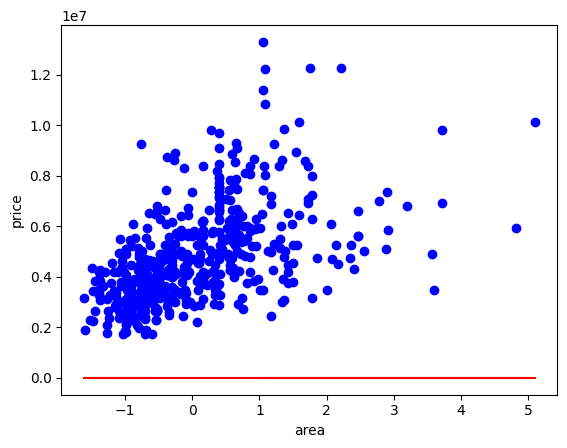

In [100]:
# Initial loss dengan data standar
current_loss = loss_fn(w, x_area_scaled, y_scaled)
print(f"Initial loss: {current_loss}")

y_hat_scaled = linear_model_1d(x_area_scaled, w)
plot_ls(x_area_scaled, y_scaled, y_hat_scaled)

### Langkah Optimasi

Kita melakukan iterasi untuk memperbarui parameter model sehingga *loss* berkurang.

(Loss, w, grad) after 1 step: 1.428653225279488e+16, [51957.953 10918.552], [-5.1957350e+09 -1.0917754e+09]


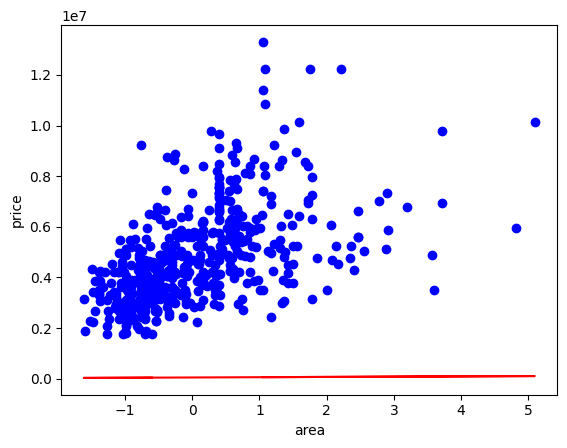

In [138]:
lrate = 1e-5 # Smaller learning rate for stability in this simple example

def update(w, x, y, lr):
    loss, grad = jax.value_and_grad(loss_fn)(w, x, y)
    w = w - lr * grad
    return w, loss, grad

# Perform one update
w, loss, grad = update(w, x_area_scaled, y, lrate)
print(f"(Loss, w, grad) after 1 step: {loss}, {w}, {grad}")

y_hat = linear_model_1d(x_area_scaled, w)
plot_ls(x_area_scaled, y, y_hat)

### Langkah 6: Proses Pelatihan Iteratif



Pada tahap ini, kita menjalankan loop untuk terus menerus:

1. Menghitung gradien berdasarkan data saat ini.

2. Menggeser bobot sedikit demi sedikit ke arah yang menurunkan error.

3. Memantau penurunan nilai *loss* di setiap epoch.

In [141]:

# Hyperparameters
lrate = 1e-6 # Learning rate stabil untuk data standar
epochs = 1000

# Inisialisasi ulang bobot
key = jax.random.PRNGKey(42)
w = jax.random.normal(key, (2,))

loss_history = []

print("Memulai pelatihan dengan data terskala...")
for i in range(epochs):
    # Gunakan x_area_scaled dan y_scaled
    w, loss, grad = update(w, x_area_scaled, y_scaled, lrate)
    loss_history.append(loss)
    
    if i % 100 == 0:
        print(f"Epoch {i}: Loss = {loss:.6f}")

print(f"\nPelatihan Selesai.")
print(f"Loss akhir: {loss_history[-1]:.6f}")

Memulai pelatihan dengan data terskala...
Epoch 0: Loss = 391.446625
Epoch 100: Loss = 390.854462
Epoch 200: Loss = 390.378479
Epoch 300: Loss = 389.995636
Epoch 400: Loss = 389.687958
Epoch 500: Loss = 389.440521
Epoch 600: Loss = 389.241516
Epoch 700: Loss = 389.081512
Epoch 800: Loss = 388.953003
Epoch 900: Loss = 388.849609

Pelatihan Selesai.
Loss akhir: 388.767212


### Visualisasi Hasil Pelatihan

Terakhir, kita visualisasikan bagaimana grafik regresi linier kita sekarang cocok dengan data setelah proses optimasi, serta melihat bagaimana nilai *loss* menurun selama iterasi.

### Visualisasi Skala Asli ###


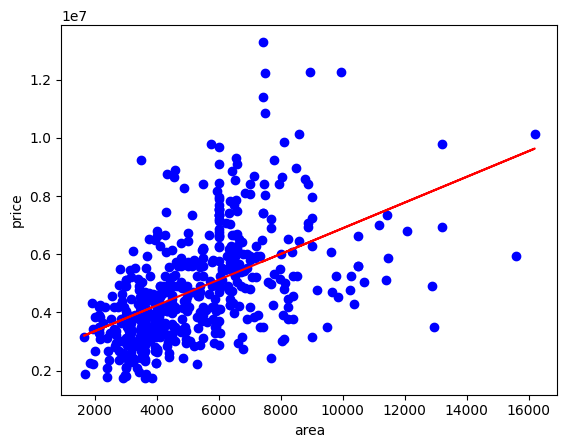

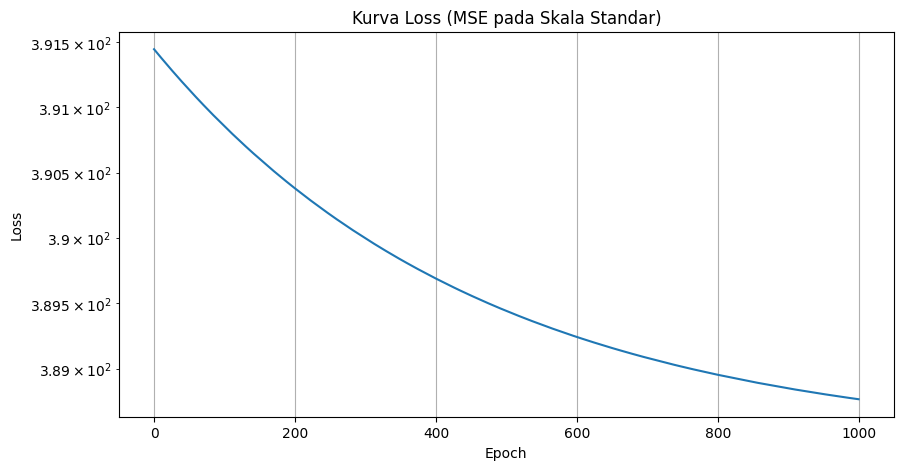

In [142]:
# 1. Prediksi dalam skala standar
y_hat_scaled = linear_model_1d(x_area_scaled, w)

# 2. Postprocessing: Inverse Transform ke skala asli
y_hat_original = y_hat_scaled * y_std + y_mean

print("### Visualisasi Skala Asli ###")
plot_ls(x_area, y_original, y_hat_original)

# Plot kurva loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history)
plt.title("Kurva Loss (MSE pada Skala Standar)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.yscale('log')
plt.grid(True)
plt.show()

### Batasan Model Linear

Mungkin Anda memperhatikan bahwa nilai *loss* tidak pernah mencapai angka nol, bahkan setelah ribuan epoch. Mengapa demikian?

1.  **Hubungan Non-Linear**: Data dunia nyata jarang sekali mengikuti garis lurus sempurna dan hanya menggunakan satu faktor/variabel. Ada faktor lain yang memengaruhi harga rumah selain luas area.
2.  **Noise**: Selalu ada variasi acak dalam data yang tidak bisa dijelaskan oleh model matematika sederhana.
3.  **Underfitting**: Model linear adalah model yang sangat sederhana. Karena keterbatasan strukturnya, ia tidak mampu menangkap kompleksitas data yang lebih tinggi. Ini kita kenal dengan istilah *underfitting*. Perlu untuk mempertimbangkan model non-linear untuk mempelajari pola data yang kompleks.

## Kesimpulan

Selamat! Anda telah membangun loop pelatihan Gradient Descent dari awal menggunakan JAX.

Beberapa poin penting yang kita pelajari:
1. **JAX Autograd Fungsional**: Menggunakan `jax.grad` pada fungsi murni.
2. **Pentingnya Scaling**: Tanpa normalisasi data, optimasi numerik seringkali gagal (`NaN`).
3. **Siklus Optimasi**: Prediksi -> Hitung Loss & Grad -> Update Bobot -> Ulangi.

Selanjutnya, Anda bisa mencoba menambahkan lebih banyak fitur (Multiple Linear Regression) atau mencoba fungsi aktivasi non-linear untuk membangun Neural Network sederhana!